## 1. 프로젝트 목표 설정

### 1) 테스트 진행 전 상황

- 온라인 교육을 제공하는 Udacity를 대상으로 A/B 테스트를 진행
- 교육 정보를 알려주는 코스 개요 페이지에 1) Start Free Trial과 2) Access Course Material 선택지가 있음
    -  Start Free Trial을 선택하면 카드 정보 입력 페이지로 연결되고, 입력을 마치면 14일 뒤에 자동 청구됨
    - Access Course Material을 선택하면 무료로 영상을 보고 퀴즈를 풀 수 있지만 코칭이나 인증서 발급을 받을 수 없음 

### 2) A/B 테스트 진행 목적

- 학생이 'Start Free Trial' 버튼을 누르고 무료 평가판 교육을 진행할 시 교육에 할애할 수 있는 시간을 입력하도록 함
- 통상적으로 소요되는 시간보다 적은 시간을 입력 시 해당 교육에 더 많은 시간이 필요하다는 경고 메시지를 출력
- 이와 같은 기능을 추가했을 때 교육에 충분한 시간을 쏟을 수 없는 사람이 무료 평가판을 등록하지 않고 떠날 것으로 기대됨

### 3) 프로젝트 효과
- 코치는 수료가능성이 높은 학생에게 집중할 수 있음

### 4) 가설 설정
- 귀무가설 : 새로운 기능을 추가하더라도 무료 평가판을 떠나지 않고 등록하는 사람의 수는 변하지 않는다.
- 대립가설 : 새로운 기능을 추가하면 무료 평가판을 등록하지 않고 떠나는 사람의 수가 유의미하게 증가한다.

## 2. 프로젝트 평가 지표 설정
### 1) 불변 지표
- 두 집단을 편향없이 비교하기 위해 테스트 진행 과정에서 변하지 않고 유지되어야 하는 지표 설정
 - 코스 개요 페이지의 쿠키 수
 - 'Start Free Trial' 버튼 클릭 수

### 2) 평가 지표
- 새로운 기능의 효과를 확인하기 위해 필요한 지표
 - Gross Conversion : Start Free Trial 버튼 클릭 수 대비 무료 과정 등록 확률
 - Retention : 무료 평가 과정 등록 대비 유료 결제 확률
 - Net Conversion : Start Free Trial 버튼 클릭 수 대비 유료 결제 등록 확률

### 3) 평가 지표에 대해 baseline 설정
- 평가 지표 상의 유의미한 변화가 있더라도 그 변화가 비즈니스 차원에서 유의미한 수익률을 보장해야 함
- 기능을 변경하는 비용 대비 평가 지표의 향상 정도가 높지 않다면 기능을 변경할 이유가 없음
 - Gross Conversion : -0.01
 - Retention : 0.01
 - Net Conversion : 0.0075 


## 3. 프로젝트 진행

In [2]:
# 모듈 import

import math as mt
import numpy as np
import pandas as pd
from scipy.stats import norm
import sklearn.utils

### 평가지표를 수립하기 위한 기본 데이터 수집(daily)

In [3]:
baseline = {"Cookies":40000,"Clicks":3200,"Enrollments":660, "Payments":350, "CTP":0.08}

### 전체 모수에서 5,000개의 쿠키만 표본으로 사용함
- 데이터의 수가 많을 수록 신뢰구간이 좁아지게 됨(데이터가 많을 수록 평균으로 수렴하는 정규분포의 특성)
- 신뢰구간이 좁아질 수록 두 집단의 작은 차이도 유의미하게 측정됨
- 무의미한 차이를 유의미한 차이로 판정하는 2종 오류를 억제하기 위해 데이터 숫자를 조정함

In [4]:
baseline["Cookies"] = 5000
baseline["Clicks"]=baseline["Clicks"]*(5000/40000)
baseline["Enrollments"]=baseline["Enrollments"]*(5000/40000)
baseline["Payments"]=baseline["Payments"]*(5000/40000)
baseline

{'CTP': 0.08,
 'Clicks': 400.0,
 'Cookies': 5000,
 'Enrollments': 82.5,
 'Payments': 43.75}

### 기본 데이터를 이용하여 평가 지표 계산

In [5]:
# 새로운 기능을 적용하기 전 평가 지표
# Gross Conversion
# Retention
# Net Conversion

baseline["GConversion"] = baseline["Enrollments"] / baseline["Clicks"]
baseline["Retention"] = baseline["Payments"] / baseline["Enrollments"]
baseline["NConversion"] = baseline["Payments"] / baseline["Clicks"]

baseline

{'CTP': 0.08,
 'Clicks': 400.0,
 'Cookies': 5000,
 'Enrollments': 82.5,
 'GConversion': 0.20625,
 'NConversion': 0.109375,
 'Payments': 43.75,
 'Retention': 0.5303030303030303}

### 지표 별 필요한 샘플 수 추산을 위해 필요한 데이터 준비

- Probability : 해당 상황이 발생할 가능성
- Numbers : 전체 표본 수
- d_min : baseline

In [6]:
GC={}
GC["d"]=0.01
GC["p"]=baseline["GConversion"]
GC["n"]=baseline["Clicks"]

In [7]:
R={}
R["d"]=0.01
R["p"]=baseline["Retention"]
R["n"]=baseline["Enrollments"]

In [8]:
NC={}
NC["d"]=0.0075
NC["p"]=baseline["NConversion"]
NC["n"]=baseline["Clicks"]

## 샘플 사이즈 계산 함수

$$(Z{_1-_{α\over 2}}*sd_1+Z_{1−β}*sd_2)^2 \over d^2$$

- 1종 오류 확률과 2종 오류 확률을 더한 뒤 detective value로 스케일링함

In [9]:
# Z-score 함수
# 95% 신뢰 수준에 대한 Z-score를 반환할 수 있도록 할 예정

def get_z_score(alpha):
    return norm.ppf(alpha)

# sd1 -> 2종 오류 : P(reject null | null true)에 대한 표준 편차
# sd2 -> 1종 오류 : P(fail to reject | null false)에 대한 표준 편차

def get_sds(p,d):
    sd1=mt.sqrt(p*(1-p) + p*(1-p))
    sd2=mt.sqrt(p*(1-p)+(p+d)*(1-(p+d)))
    sds=[sd1,sd2]
    return sds

def get_sampSize(sds,alpha,beta,d):
    n=pow((get_z_score(1-alpha/2)*sds[0]+get_z_score(1-beta)*sds[1]),2)/pow(d,2)
    return n

## 샘플 사이즈 계산

- Gross Conversion의 유의수준을 측정하기 위해서 25,835개의 Click 수(Cookies)가 필요함


In [10]:
GC["SampSize"]=round(get_sampSize(get_sds(GC["p"],GC["d"]),0.05,0.2,GC["d"]))
GC["SampSize"]

25835

- 현재 5,000 페이지 조회수(Cookies) 당 400개의 클릭이 발생하고 있음. 즉, 클릭 수 하나당 12.5개의 페이지 조회수가 필요함
- 위와 같은 비율에서 25,835개의 Click 수를 얻기 위해서 25,835 * 12.5(5000/400)개의 페이지 조회수가 필요함
- A/B 양 집단에 사용할 샘플이 필요하기 때문에 2를 곱함


In [11]:
GC["SampSize"]=round(GC["SampSize"]*12.5*2)
GC["SampSize"]

645875

- Retention의 유의수준을 측정하기 위해서 39,084명의 등록자가 필요함

In [12]:
R["SampSize"]=round(get_sampSize(get_sds(R["p"],R["d"]),0.05,0.2,R["d"]))
R["SampSize"]

39084

- 39,087명의 등록자를 얻기 위해서는 한명 당 등록 페이지에 진입하기 위해 필요한 페이지 갯수가 필요함(12.5개)
- 한 명을 등록하기 위해 필요한 클릭 수가 필요함(=Gross Conversion(0.20625))
- A/B 양 집단에 사용할 샘플이 필요하기 때문에 2를 곱함

In [13]:
R["SampSize"]=R["SampSize"]/0.08/0.20625*2
R["SampSize"]

4737454.545454546

- Net Conversion을 측정하기 위해 27,427개의 클릭수가 필요함

In [14]:
NC["SampSize"]=round(get_sampSize(get_sds(NC["p"],NC["d"]),0.05,0.2,NC["d"]))
NC["SampSize"]

27427

- 5,000 페이지 조회수(Cookies) 당 400개의 클릭이 발생하고 있음. 즉, 클릭 수 하나당 12.5개의 페이지 조회수가 필요함
- 위와 같은 비율에서 25,835개의 Click 수를 얻기 위해서 27,427 * 12.5(5000/400)개의 페이지 조회수가 필요함
- A/B 양 집단에 사용할 샘플이 필요하기 때문에 2를 곱함

In [15]:
NC["SampSize"]=NC["SampSize"]/0.08*2
NC["SampSize"]

685675.0

## 샘플 사이즈 선택

- 지표 당 필요한 샘플 사이즈(페이지 조회 수)
 - GC : 645,875
 - R : 4,737,454
 - NC : 685,675

- 하루에 약 40,000 건의 페이지 조회가 발생하고 있음. 각 지표에 필요한 샘플 사이즈를 얻기 위해 필요한 데이터 수집 기간은 다음과 같음
 - GC : 17일(645875 / 40000)
 - R : 119일(4737454 / 40000)
 - NC : 18일(685675 / 40000)

- 현실적으로 119일동안 A/B 테스트를 진행하기 어려움
- NC의 샘플 사이즈를 선택하면 GC의 샘플 사이즈 수도 포괄할 수 있음(Retention에 대한 테스트는 진행할 수 없음)
- **A/B 테스트를 위해 수집할 샘플의 사이즈는 685,675개로 선택**

## 수집한 데이터 분석

### EDA

In [59]:
import seaborn as sns

In [110]:
control = pd.read_csv("/content/drive/MyDrive/A-B-test_data/control_data.csv")
experiment = pd.read_csv("/content/drive/MyDrive/A-B-test_data/experiment_data.csv")

In [111]:
control.head()

,Date,Pageviews,Clicks,Enrollments,Payments
0,"Sat, Oct 11",7723,687,134.0,70.0
1,"Sun, Oct 12",9102,779,147.0,70.0
2,"Mon, Oct 13",10511,909,167.0,95.0
3,"Tue, Oct 14",9871,836,156.0,105.0
4,"Wed, Oct 15",10014,837,163.0,64.0


### 1) 데이터 분포 확인

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


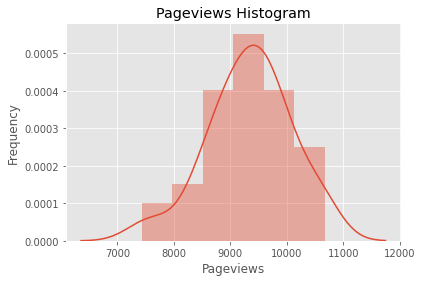

In [112]:
def print_dist(group, feature):
    ax = plt.subplots()
    ax = sns.distplot(group[feature])
    ax.set_title(f"{feature} Histogram")
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

print_dist(control, 'Pageviews')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


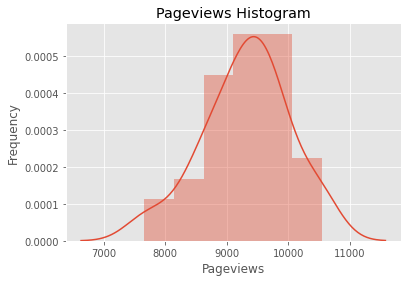

In [113]:
print_dist(experiment, 'Pageviews')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


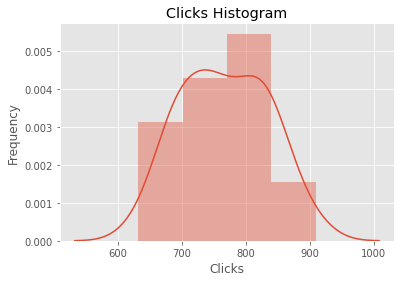

In [114]:
print_dist(control, 'Clicks')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


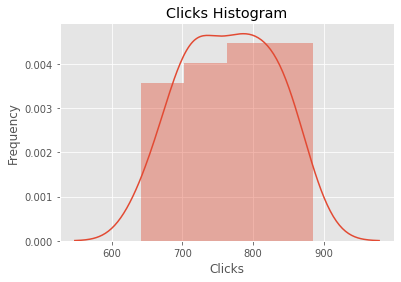

In [115]:
print_dist(experiment, 'Clicks')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


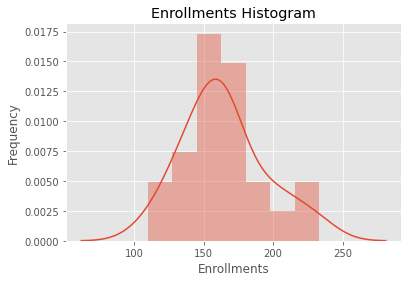

In [116]:
print_dist(control, 'Enrollments')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


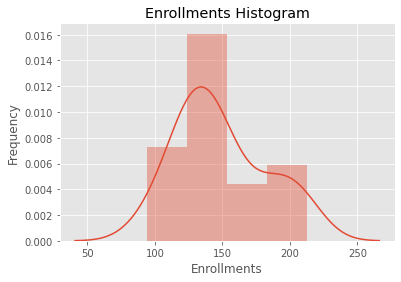

In [117]:
print_dist(experiment, 'Enrollments')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


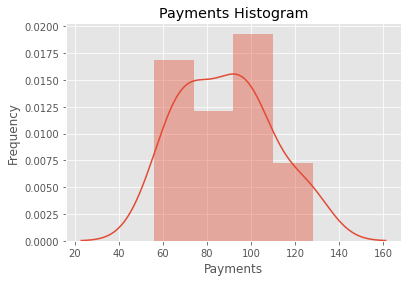

In [118]:
print_dist(control, 'Payments')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


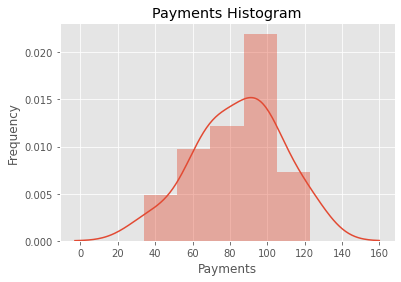

In [119]:
print_dist(experiment, 'Payments')

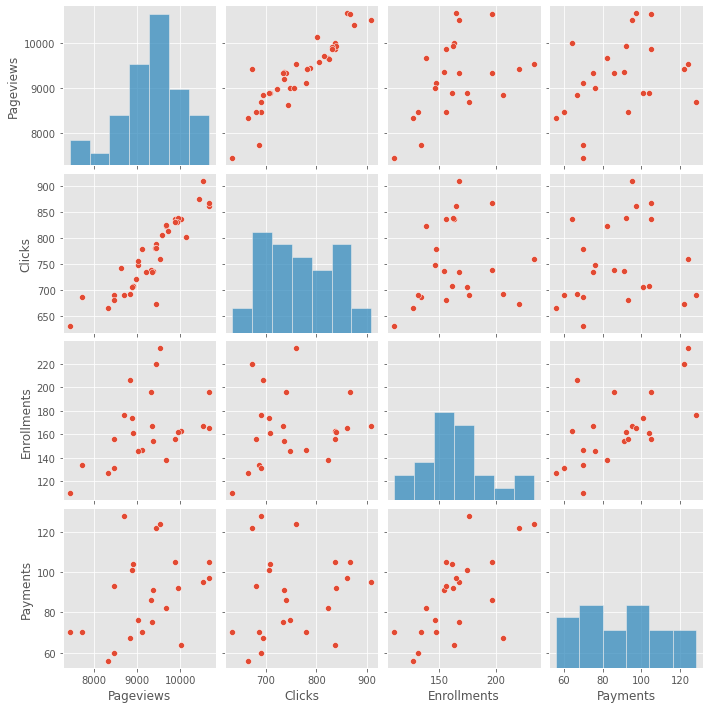

In [120]:
# 통제집단 변수들 간의 상관 관계
# 주요 지표인 Enrollments와 Payments와 유의미한 관계가 있는 변수 확인

fig = sns.pairplot(control)

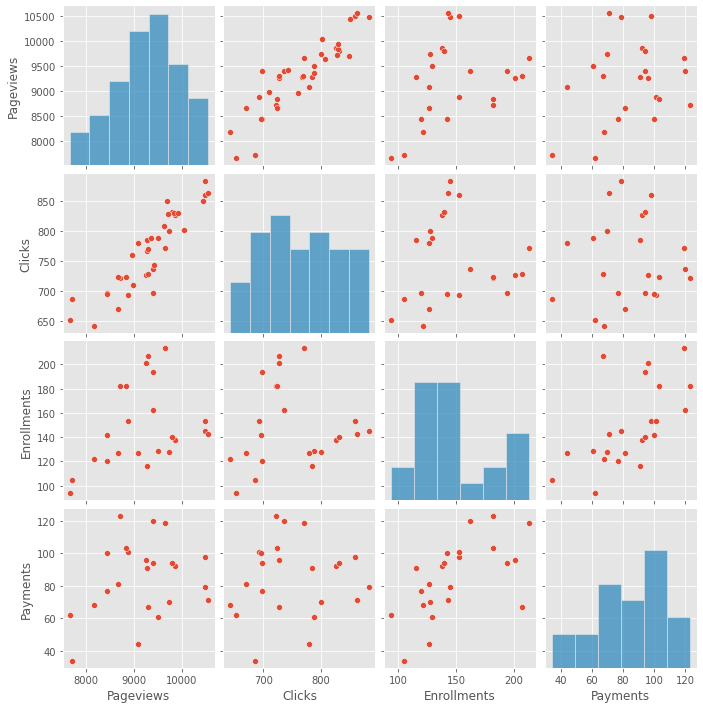

In [121]:
# 실험집단 변수들 간의 상관 관계
# 주요 지표인 Enrollments와 Payments와 유의미한 관계가 있는 변수 확인


fig = sns.pairplot(experiment)

### 시각화 결과 정리

- 데이터에 이상치 없음 확인
- 데이터가 정규분포의 형태를 띄고 있는 것 확인

#### 1) Enrollments
- 명확한 선형관계를 보이는 피쳐는 Payments
- Click과 Pageview 특성과도 약한 선형 관계를 이루고 있는 것처럼 보임

### 2) Payments
- Enrollments 외에는 선형 관계를 이루고 있는 데이터가 없는 것으로 보임

## 수집한 데이터 간의 불변 지표 평가

### 1. 페이지 뷰 불변 지표 평가

- A/B 두 집단의 샘플 사이즈에 유의미한 차이가 없다는 것을 확인해야 함

1) pageview
- control과 experiment의 페이지 뷰에 유의미한 차이가 있어선 안됨

In [131]:
# 통제 그룹의 Pageviews 
pageviews_cont = control['Pageviews'].sum()

# 실험 그룹의 Pageviews
pageviews_exp = experiment['Pageviews'].sum()

# 샘플링된 전체 Pageviews
pageviews_total = pageviews_cont+pageviews_exp

print("control 그룹(통제군)의 페이지 조회 수 :", pageviews_cont)
print("experiment 그룹(실험군)의 페이지 조회 수 :" ,pageviews_exp)
print("두 샘플의 차이 :", pageviews_cont - pageviews_exp)
print("샘플링된 총 페이지 조회 수 :", pageviews_total)

control 그룹(통제군)의 페이지 조회 수 : 345543
experiment 그룹(실험군)의 페이지 조회 수 : 344660
두 샘플의 차이 : 883
샘플링된 총 페이지 조회 수 : 690203


- 전체 데이터에 대해 control과 experiment 데이터의 비율은 0.5이여야 샘플 사이즈에 편향이 없다고 볼 수 있음
- 0.5에 대한 허용 오차를 구하고, 전체 데이터에 대한 A/B 샘플 사이즈가 허용 오차 안에 위치하는 지 확인함

In [19]:
p_hat_cont = round(pageviews_cont/(pageviews_total),4)
p_hat_exp = round(pageviews_exp/(pageviews_total),4)

print("통제군의 데이터 비율 :", p_hat_cont)
print("실험군의 데이터 비율 :", p_hat_exp)

통제군의 데이터 비율 : 0.5006
실험군의 데이터 비율 : 0.4994


- 가설 설정
 - 귀무가설 : 통제군(실험군)의 데이터 비율과 0.5는 통계적으로 유의미한 차이가 없다
 - 대립가설 : 통제군(실험군)의 데이터 비율과 0.5는 통계적으로 유의미한 차이가 있다.

- Margin of error을 통한 신뢰수준 계산
 - 허용오차 z-score * se로 계산됨
 - z-score는 평균이 0이고 표준편차가 1인 정규분포 곡선에서 도출할 수 있음. 통상적으로 95% 신뢰구간을 설정하면, z-score는 +-1.96이 도출됨
 - 표준오차는 p값, 즉 성공가능성의 크기에 의해 좌우됨. 0.5보다 작아지거나 커지면 표본 오차가 작아지고, 신뢰구간이 좁아짐. 0.5일 때 불확실성이 가장 크다는 의미
 - 오차허용 범위는 정규분포상에서 설정한 신뢰구간 범위(+-1.96)를 SE로 scaling한 것이라고 이해할 수 있음.
 - 해당 오차허용 범위로 신뢰구간을 설정함

In [20]:
p = 0.5
alpha = 0.05
sd = mt.sqrt(p*(1-p)/(pageviews_total))
ME = round(get_z_score(1-(alpha/2))*sd,4)

print(f"신뢰구간 : {p-ME}~{p+ME}")
print(f"신뢰구간 안에 {p_hat_cont}과 {p_hat_exp}이 포함되어야 A/A 테스트 통과")

신뢰구간 : 0.4988~0.5012
신뢰구간 안에 0.5006과 0.4994이 포함되어야 A/A 테스트 통과


- 통제군과 실험군의 비율이 95% 신뢰도에서 0.5 +-0.012 구간 안에 위치하는 것을 확인 -> 귀무가설 채택

2) 'Start Free Trial' 버튼 클릭 수

- 가설 설정

 - 귀무가설 : 통제군(실험군)의 데이터 비율과 0.5는 통계적으로 유의미한 차이가 없다
 - 대립가설 : 통제군(실험군)의 데이터 비율과 0.5는 통계적으로 유의미한 차이가 있다.

In [132]:
clicks_cont = control['Clicks'].sum()
clicks_exp = experiment['Clicks'].sum()
clicks_total = clicks_cont + clicks_exp

print("두 샘플의 차이 :", clicks_cont - clicks_exp)

두 샘플의 차이 : 53


In [22]:
p_hat_cont = round(clicks_cont / clicks_total, 4)
p_hat_exp = round(clicks_exp / clicks_total, 4)

print("통제군의 데이터 비율 :", p_hat_cont)
print("실험군의 데이터 비율 :", p_hat_exp)

통제군의 데이터 비율 : 0.5005
실험군의 데이터 비율 : 0.4995


In [23]:
p = 0.5
alpha = 0.05
sd = mt.sqrt(p*(1-p)/(clicks_total))
ME = round(get_z_score(1-(alpha/2))*sd,4)

print(f"신뢰구간 : {p-ME}~{p+ME}")
print(f"신뢰구간 안에 {p_hat_cont}과 {p_hat_exp}이 포함되어야 A/A 테스트 통과")

신뢰구간 : 0.4959~0.5041
신뢰구간 안에 0.5005과 0.4995이 포함되어야 A/A 테스트 통과


- 통제군과 실험군의 비율이 95% 신뢰도에서 0.5 +-0.041 구간 안에 위치하는 것을 확인 -> 귀무가설 채택

## A/B 테스트 평가 지표 분석

### 1. A/B test 평가 지표 확인(효과 크기)

#### 목표 : A/B 집단의 평가 지표 간의 유의미한 변화가 있는 것을 확인해야 함

#### 효과 크기(Effect size)
- 두 변수 사이의 연관성 정도를 의미함
- 효과 크기가 0이라는 것은 비교 집단들 사이의 차이(연관성)이 없다는 것을 의미함
- 비교하려는 집단 사이의 차이가 클 수록 효과 크기가 커지게 됨

1) Gross Conversion

In [24]:
# 결측치 제외

clicks_cont=control["Clicks"].loc[control["Enrollments"].notnull()].sum()
clicks_exp=experiment["Clicks"].loc[experiment["Enrollments"].notnull()].sum()

In [25]:
# Gross Conversion = Enrollments / Clicks
# 통제군&실험군 GC 계산

enrollments_cont = control["Enrollments"].sum()
enrollments_exp = experiment["Enrollments"].sum()

GC_cont = enrollments_cont / clicks_cont
GC_exp = enrollments_exp / clicks_exp

# 합동 표준편차 계산 -> 합동 표준편차를 통해 신뢰구간 계산
    # GC_pooled : 두 샘플의 총 Gross Conversion Probability
    # GC_sd_pooled : 합동 표준편차
    # GC_ME : Margin of Error

GC_pooled = (enrollments_cont + enrollments_exp) / (clicks_cont + clicks_exp)
GC_sd_pooled = mt.sqrt(GC_pooled*(1-GC_pooled) * (1/clicks_cont + 1/clicks_exp))
GC_ME=round(get_z_score(1-alpha/2) * GC_sd_pooled, 4)

GC_d_hat = round(GC_exp - GC_cont, 4)

In [26]:
print(f"- 통제군과 실험군의 차이 : {GC_d_hat}")
print(f"- 두 집단의 차이는 95% 확률로 [{GC_d_hat - GC_ME} ~ {GC_d_hat + GC_ME}] 안에서 형성될 가능성이 높음")
print("- 신뢰 구간 안에 0이 포함되어 있지 않으므로 통게적으로 두 집단의 GC 차이는 통계적으로 유의미함")
print("- 또한, 신뢰 구간의 범위가 baseline인 -0.01보다 작으므로 실질적으로도 유의미한 차이라고 볼 수 있음")

- 통제군과 실험군의 차이 : -0.0206
- 두 집단의 차이는 95% 확률로 [-0.0292 ~ -0.012] 안에서 형성될 가능성이 높음
- 신뢰 구간 안에 0이 포함되어 있지 않으므로 통게적으로 두 집단의 GC 차이는 통계적으로 유의미함
- 또한, 신뢰 구간의 범위가 baseline인 -0.01보다 작으므로 실질적으로도 유의미한 차이라고 볼 수 있음


2) Net Conversion

In [27]:
# Gross Conversion = Enrollments / Clicks
# 통제군&실험군 NC 계산

payments_cont = control["Payments"].sum()
payments_exp = experiment["Payments"].sum()

NC_cont = payments_cont / clicks_cont
NC_exp = payments_exp / clicks_exp

# 합동 표준편차 계산 -> 합동 표준편차를 통해 신뢰구간 계산
    # NC_pooled : 두 샘플의 총 Net Conversion Probability
    # NC_sd_pooled : 합동 표준편차
    # NC_ME : Margin of Error

NC_pooled = (payments_cont+payments_exp) / (clicks_cont + clicks_exp)
NC_sd_pooled = mt.sqrt(NC_pooled*(1-NC_pooled) * (1/clicks_cont + 1/clicks_exp))
NC_ME = round(get_z_score(1-alpha/2) * NC_sd_pooled, 4)

NC_d_hat = round(NC_exp - NC_cont, 4)

In [28]:
print(f"- 통제군과 실험군의 차이 : {NC_d_hat}")
print(f"- 두 집단의 차이는 95% 확률로 [{NC_d_hat - NC_ME} ~ {NC_d_hat + NC_ME}] 안에서 형성될 가능성이 높음")
print("- 신뢰 구간 안에 0이 포함되어 있으므로 두 집단의 차이는 통계적으로 유의하지 않을 가능성이 있음")
print("- 또한, 신뢰 구간의 범위가 baseline인 0.075보다 작기 때문에 실질적으로도 유의미한 차이라고 볼 수 없음")

- 통제군과 실험군의 차이 : -0.0049
- 두 집단의 차이는 95% 확률로 [-0.0116 ~ 0.0018000000000000004] 안에서 형성될 가능성이 높음
- 신뢰 구간 안에 0이 포함되어 있으므로 두 집단의 차이는 통계적으로 유의하지 않을 가능성이 있음
- 또한, 신뢰 구간의 범위가 baseline인 0.075보다 작기 때문에 실질적으로도 유의미한 차이라고 볼 수 없음


### 2. A/B test 평가 지표 확인(부호 검정)

#### 목표 : 효과 크기 방식의 A/B test 결과를 재검증함

#### 부호검정(sign test)
- 비교하려는 지표(변수) 간에 비교된 크기 외에 다른 정보는 모두 무시하는 검정 방법
- 평균값을 기반으로 한 효과 크기 방식의 검정은 이상치에 취약하기 때문에 이상치의 영향을 덜 받는 sign test로 분석 결과를 cross check 함

#### 진행 방법

1) 통제군과 실험군의 크기를 daily 단위로 비교하여 이진 분류함(통제군이 크면 0, 실험군이 크면 1)

2) 0과 1로 분류된 데이터를 집계함

  - 귀무가설 : 통제군(실험군)의 비율이 0.5와 유의미한 차이가 없을 것이다.
  - 대립가설 : 통제군(실험군)의 비율이 0.5와 유의미한 차이가 있을 것이다.

3) 통제군(실험군)의 비율과 신뢰수준을 통해 p-value를 계산함


In [29]:
# 두 지표의 크기를 비교하기 위해 df 병합
full = control.join(other=experiment, how="inner", lsuffix="_cont", rsuffix="_exp")

full.head()

,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0


In [30]:
#결측치 확인

full.isnull().sum()

Date_cont            0
Pageviews_cont       0
Clicks_cont          0
Enrollments_cont    14
Payments_cont       14
Date_exp             0
Pageviews_exp        0
Clicks_exp           0
Enrollments_exp     14
Payments_exp        14
dtype: int64

In [31]:
# 결측치 제거

full = full.loc[full["Enrollments_cont"].notnull()]
full.isnull().sum()

Date_cont           0
Pageviews_cont      0
Clicks_cont         0
Enrollments_cont    0
Payments_cont       0
Date_exp            0
Pageviews_exp       0
Clicks_exp          0
Enrollments_exp     0
Payments_exp        0
dtype: int64

In [32]:
# 평가지표 비교 결과를 저장한 새로운 컬럼 생성

x = full['Enrollments_cont'] / full['Clicks_cont']
y = full['Enrollments_exp'] / full['Clicks_exp']

#실험군이 더 크면 1, 그렇지 않으면 0
full['GC'] = np.where(x<y, 1, 0)

z = full['Payments_cont'] / full['Clicks_cont']
w = full['Payments_exp'] / full['Clicks_exp']

#실험군이 더 크면 1, 그렇지 않으면 0
full['NC'] = np.where(z<w, 1, 0)
full.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Date_cont,Pageviews_cont,Clicks_cont,Enrollments_cont,Payments_cont,Date_exp,Pageviews_exp,Clicks_exp,Enrollments_exp,Payments_exp,GC,NC
0,"Sat, Oct 11",7723,687,134.0,70.0,"Sat, Oct 11",7716,686,105.0,34.0,0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,"Sun, Oct 12",9288,785,116.0,91.0,0,1
2,"Mon, Oct 13",10511,909,167.0,95.0,"Mon, Oct 13",10480,884,145.0,79.0,0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,"Tue, Oct 14",9867,827,138.0,92.0,0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,"Wed, Oct 15",9793,832,140.0,94.0,0,1


In [33]:
# 부호 집계

GC_x = full.GC[full["GC"]==1].count()
NC_x = full.NC[full["NC"]==1].count()
n = full.Date_cont.count()

print(f"GC 지표에서 실험군이 더 큰 케이스 수 : {GC_x}")
print(f"NC 지표에서 실험군이 더 큰 케이스 수 : {NC_x}")
print(f"전체 케이스 수 : {n}")

GC 지표에서 실험군이 더 큰 케이스 수 : 4
NC 지표에서 실험군이 더 큰 케이스 수 : 10
전체 케이스 수 : 23


In [34]:
# p-value 계산을 위한 함수
# x : 실험군이 더 큰 케이스 수
# n : 전체 케이스 수

def get_prob(x,n):
    p = round(mt.factorial(n)/(mt.factorial(x)*mt.factorial(n-x))*0.5**x*0.5**(n-x), 4)
    return p

def get_2side_pvalue(x,n):
    p = 0
    for i in range(0, x+1):
        p = p + get_prob(i, n)
    return round(2*p, 4)

In [35]:
print("GC의 p-value가 0.05보다 작으면 유의미함 : ",get_2side_pvalue(GC_x,n))
print("NC의 p-value가 0.05보다 작으면 유의미함 : ",get_2side_pvalue(NC_x,n))

GC의 p-value가 0.05보다 작으면 유의미함 :  0.0026
NC의 p-value가 0.05보다 작으면 유의미함 :  0.6774


## 머신러닝을 이용한 A/B 테스트

- 통계적 A/B 테스트를 진행하면 두 집단 간의 차이를 비교하여 새롭게 추가된 기능이 특정 집단에 어떤 영향을 주었는지 추정할 수 있음
- 하지만, 두 집단에 차이를 일으킨 요인이 어떤 요인인지 추정만할 수 있을 뿐, 정확히 어떤 특성이 타겟 지표에 영향을 주었는지는 알 수 없음
- 머신러닝은 어떤 특성이 타겟 지표에 영향을 주었는지 살펴볼 수 있다는 장점이 있음(설명력)
- 머신러닝을 활용하여 어떤 특성이 타겟 지표에 영향을 주었으며, 특히나 영향력이 강한 특성이 무엇인지 살펴보도록 하겠음

In [122]:
control = pd.read_csv("/content/drive/MyDrive/A-B-test_data/control_data.csv")
experiment = pd.read_csv("/content/drive/MyDrive/A-B-test_data/experiment_data.csv")

In [123]:
# 통제군, 실험군을 비교하기 위해 실험군 데이터에 1을 부여
# 통제군, 실험군을 비교하기 위해 통제군 데이터에 1을 부여

experiment['Experiment'] = 1
control['Experiment'] = 0

In [124]:
# 타겟 데이터에 대한 피쳐의 영향력을 측정하기 위해 데이터를 merge함
# 통제군, 실험군을 비교하기 위해 통제군 데이터에 1을 부여

full = pd.concat([control, experiment])
full['Experiment'] = full['Experiment'].fillna(0)
full.head()

,Date,Pageviews,Clicks,Enrollments,Payments,Experiment
0,"Sat, Oct 11",7723,687,134.0,70.0,0
1,"Sun, Oct 12",9102,779,147.0,70.0,0
2,"Mon, Oct 13",10511,909,167.0,95.0,0
3,"Tue, Oct 14",9871,836,156.0,105.0,0
4,"Wed, Oct 15",10014,837,163.0,64.0,0


### 데이터 전처리

In [39]:
# 시드 고정
np.random.seed(7)


# 연속형 데이터가 아니므로 date에서 요일만 남김
full['DOW'] = full['Date'].str.slice(start=0, stop=3)

# 결측치 처리
full.dropna(inplace=True)

# feature 순서 정리 및 필요없는 컬럼 삭제
full = full[['Experiment', 'Pageviews', 'Clicks', 'DOW', 'Enrollments']]

# 편향을 방지하기 위해 데이터 셔플

full = sklearn.utils.shuffle(full)

In [40]:
full.head()

,Experiment,Pageviews,Clicks,DOW,Enrollments
13,0,9434,673,Fri,220.0
20,0,8890,706,Fri,174.0
15,0,8896,708,Sun,161.0
18,0,9327,739,Wed,196.0
22,0,8836,693,Sun,206.0


In [41]:
# 타겟 및 훈련 피쳐 설정

target = "Enrollments"
full_train = full.drop(columns = target)

In [42]:
# 범주형 데이터 인코딩

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
full_train['DOW'] = encoder.fit_transform(full_train['DOW'])

In [43]:
# 학습 - 검증 데이터 분리

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(full_train, full[target], test_size = 0.2, random_state=2)

In [44]:
X_train.shape[0] + X_test.shape[0] == full.shape[0]

True

In [45]:
X_train.head()

,Experiment,Pageviews,Clicks,DOW
15,0,8896,708,3
10,1,10551,864,5
9,0,10667,861,1
7,0,7434,632,2
6,0,9008,748,0


In [46]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 평가 지표 함수

def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r_score = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    print("RMSE_score :", rmse)
    print("R2_socre :", r_score)
    print("MAE_score :", mae)


# 시각화 함수

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

def plot_pred(y_test, y_pred, model_name):
    N = len(y_test)
    plt.figure(figsize=(10,5)) # 그래프 사이즈
    original = plt.scatter(np.arange(1, N+1), y_test, c='blue') # train 데이터의 위치 표시
    prediction = plt.scatter(np.arange(1, N+1), y_pred, c='red')
    plt.xticks(np.arange(1, N+1)) # X축 길이
    plt.xlabel('Observation')
    plt.ylabel('Enrollments(Label)')
    title = f"True Labels vs. Predicted Labels ({model_name})"
    plt.title(title)
    plt.legend((original, prediction), ('Original', 'Prediction'))
    plt.show()


## Model 1. Linear Regression

In [47]:
import statsmodels.api as sm

linear_regression = sm.OLS(y_train, X_train)
linear_regression = linear_regression.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [48]:
y_pred = linear_regression.predict(X_test)

print_metrics(y_test, y_pred)

RMSE_score : 17.571352483434456
R2_socre : 0.715225578217028
MAE_score : 16.18243561085952


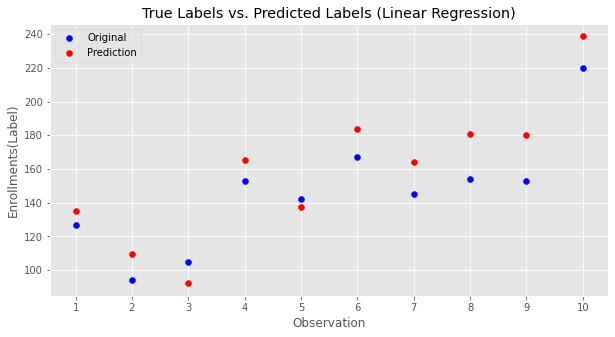

In [49]:
plot_pred(y_test, y_pred, 'Linear Regression')

In [50]:
print(linear_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:            Enrollments   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.977
Method:                 Least Squares   F-statistic:                              382.9
Date:                Fri, 29 Apr 2022   Prob (F-statistic):                    1.58e-26
Time:                        11:31:49   Log-Likelihood:                         -164.38
No. Observations:                  36   AIC:                                      336.8
Df Residuals:                      32   BIC:                                      343.1
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [52]:
pd.DataFrame(linear_regression.pvalues).reset_index().rename(columns={'index':'Terms', 0:'p_value'}).sort_values('p_value')

,Terms,p_value
1,Pageviews,0.000007
2,Clicks,0.000479
0,Experiment,0.120302
3,DOW,0.214316


## Model 2 : Decision Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, random_state=2)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print_metrics(y_test, y_pred)

RMSE_score : 22.543891430192936
R2_socre : 0.5312423530563304
MAE_score : 20.735714285714288


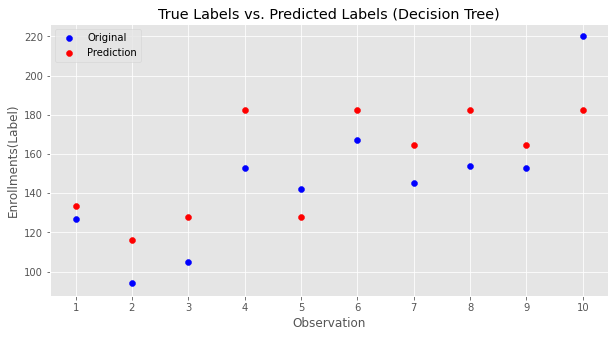

In [54]:
plot_pred(y_test, y_pred, 'Decision Tree')

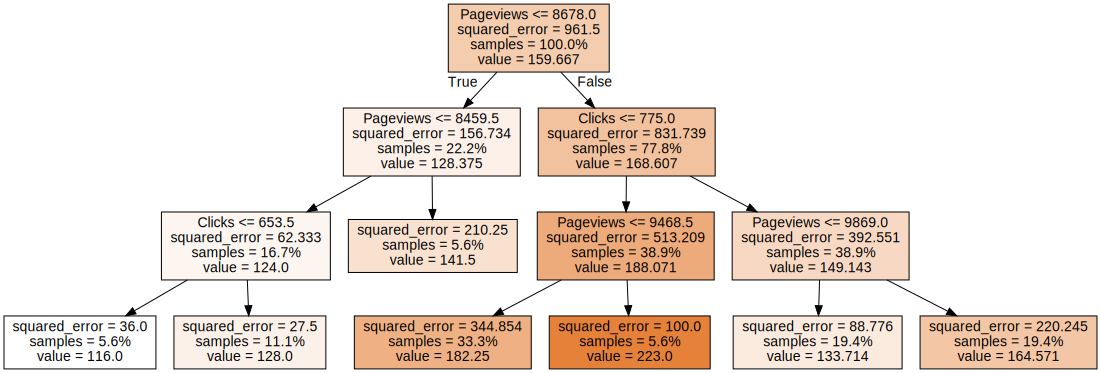

In [55]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree
                          , max_depth=6
                          , feature_names=X_train.columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)

display(graphviz.Source(dot_data))

## Model 3 : XGBoost

In [56]:
from xgboost import XGBRegressor

XGB = XGBRegressor(max_depth= 5,
                   objective='reg:linear',
                   booster= 'gblinear',
                   n_estimators= 1000,
                   learning_rate = 0.2,
                   gamma = 0.01,
                   random_state = 2,
                   subsample = 1)

XGB.fit(X_train, y_train)

[11:31:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(booster='gblinear', gamma=0.01, learning_rate=0.2, max_depth=5,
             n_estimators=1000, random_state=2)

In [57]:
y_pred = XGB.predict(X_test)
print_metrics(y_test, y_pred)

RMSE_score : 31.536692085228957
R2_socre : 0.08267575384749792
MAE_score : 26.24346160888672


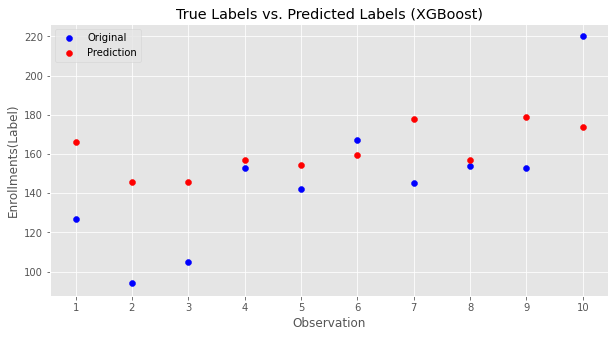

In [58]:
plot_pred(y_test, y_pred, 'XGBoost')

### 머신러닝 순열 중요도 구현

- 데이터의 갯수가 적기 때문에 XGB의 성능이 현저히 떨어짐
- 단순한 데이터에 대해서는 Linear 모델의 성능이 뛰어남
- 

In [134]:
!pip install eli5

     |████████████████████████████████| 106 kB 8.4 MB/s 


In [157]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    tree, # model
    scoring='neg_mean_squared_log_error', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)


In [158]:
permuter.fit(X_train, y_train)

PermutationImportance(estimator=DecisionTreeRegressor(max_depth=3,
                                                      min_samples_leaf=2,
                                                      random_state=2),
                      random_state=2, scoring='neg_mean_squared_log_error')

In [159]:
feature_names = X_train.columns.tolist()

In [161]:
importances = pd.Series(permuter.feature_importances_, feature_names).sort_values()

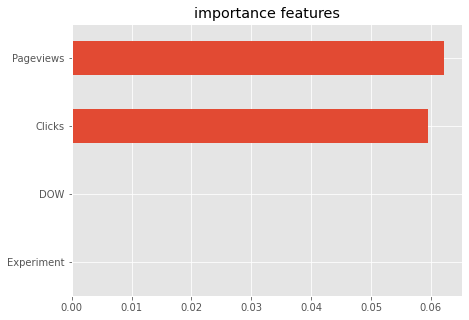

In [169]:
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(7,5))
plt.title('importance features')
importances.sort_values()[-n:].plot.barh();

### 머신러닝 결과 해석



1) 모델 성능

- 데이터의 갯수가 적기 때문에 XGB의 성능이 현저히 떨어짐
- 단순한 데이터에 대해서는 Linear 모델의 성능이 뛰어남
- Tree 모델도 준수한 성능을 보였으나, Linear 모델의 성능이 더욱 뛰어난 것을 확인

2) 특성 간 관계 분석
- 'Start free trial' 버튼 클릭 수가 많아질 수록 'Enrollments(과정 무료 등록)'는 감소함 
  - Enrollments 감소를 의도한 실험군 데이터가 섞여 있기 때문에 Enrollments가 감소한 것으로 보임
  - 즉, 새로운 기능이 Enrollments 감소에 유의미한 역할을 한다고 해석할 수 있음
- 'Course overview' 페이지 조회 수가 많아질 수록 'Enrollments(과정 무료 등록)'는 증가함
  - Course overview 페이지에는 Enrollment 감소를 위한 별도의 기능을 추가하지 않았기 때문에 페이지 조회수가 늘수록 Enrollment가 증가하는 것으로 볼 수 있음
  - Enrollment를 더 줄이려는 비즈니스 목적이 있다면 Course overview 페이지에도 새로운 기능을 추가하는 것이 좋음

- 실험군일 때 Enrollments의 감소가 나타남
  - 실험군 여부와 Enrollments는 음의 회귀계수로 나타남
  - 다만, 통계적으로 유의미한 수준은 아니기 때문에 해석에 주의가 필요함

3) Enrollments에 영향을 주는 주요 특성
- Pageviews와 Clicks이 Enrollments에 가장 큰 영향을 미침
- 비즈니스 목적을 달성하기 위해서 Pageview와 Click을 조절할 필요가 있음